In [3]:
import meshio
import pygalmesh
import numpy as np
import copy
from mshr import *
from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *

# Initialisation

User settings: What are the continuum parameters we want? 

In [4]:
# Target mesh size:
target_a = 0.2
# continuum bending modulus:
kc=1
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
B=10
# the spring prestress values 
g0start=1.0
g0end=4.0
g0step=0.1

User settings for the experimental run: What are the continuum parameters we want? 

In [5]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
#RunFolder="kc_"+"{0:0.1f}".format(kc)+"_B_"+"{0:0.1f}".format(B)+"/"
RunFolder="Scratch/"
# Name of the run
RunName=""
# Name of the current file
ScriptName="EnergyMinimizationScript.ipynb"

Right, lets define the bond type and parameters for each bond. In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [6]:
kd=kc/target_a
k = mu
theta0=np.pi

Set up the experiment

In [7]:
path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder if there was a previous run in it
#for filename in os.listdir(path):
#    file_path = os.path.join(path, filename)
#    try:
#        if os.path.isfile(file_path) or os.path.islink(file_path):
#            os.unlink(file_path)
#        elif os.path.isdir(file_path):
#            shutil.rmtree(file_path)
#    except Exception as e:
#        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
        
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "B":B,
        "mu":mu,
        "g0start":g0start,
        "g0end":g0end,
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+RunFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/Scratch/ failed


FileNotFoundError: [Errno 2] No such file or directory: 'EnergyMinimizationScript.ipynb'

Make the mesh, write it out to the folder

In [8]:
InputMesh= MakeDolfinMesh3D(target_a,40)
OutputMesh = copy.deepcopy(InputMesh)
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk")

Make the bond lists etc.

In [9]:
interiorbonds,edgebonds,boundarytris= MakeBondAngleLists3D(InputMesh)

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.30582535671506506

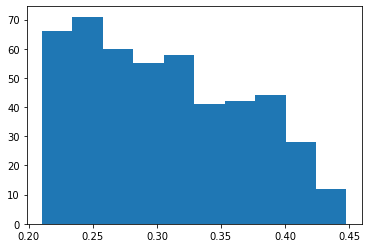

In [10]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)

# Energy Minimization

In [11]:
g0temp=1.5

In [13]:
# initial input points. Pout changes over time
Pout_ij =InputMesh.points 
N = len(Pout_ij)

# preferred rest lengths
i=np.array(interiorbonds)
e=np.array(edgebonds)



In [25]:
Pout_ij =InputMesh.points

In [29]:
unrav=Pout_ij.ravel()
rerav= unrav.reshape((-1, 3))

In [30]:
rerav

array([[-5.06550648e-01,  4.33715144e-01,  3.18371856e-01],
       [-4.20599759e-01,  2.52421817e-01,  5.26381987e-01],
       [-1.60255542e-01,  5.95429914e-01,  3.80228706e-01],
       [-3.76425241e-01,  5.83094780e-01,  7.08005575e-01],
       [ 3.29778694e-01,  8.46608603e-01, -4.02257972e-01],
       [ 2.78424515e-01,  5.60142602e-01, -3.21837498e-01],
       [ 2.67681534e-01,  6.74007743e-01, -5.02980679e-02],
       [ 2.48617773e-01,  9.47260670e-01, -1.81192280e-01],
       [ 5.10909286e-02, -9.08394516e-01,  4.07628105e-01],
       [-6.21217408e-02, -7.42489761e-01,  6.59386754e-01],
       [-1.55454861e-02, -4.93774224e-01,  3.10433401e-01],
       [-3.23011717e-01, -8.48968544e-01,  4.03768788e-01],
       [ 6.20370107e-01,  1.05579076e-01,  3.79079604e-01],
       [ 9.44867704e-01,  8.71116563e-02,  3.03156079e-01],
       [ 6.45311467e-01,  3.31294791e-01,  2.34661300e-01],
       [ 8.11107106e-01,  3.24442842e-01,  4.86664263e-01],
       [-5.95989211e-01,  4.49580848e-01

In [ ]:
# initial input points. Pout changes over time
Pout_ij =InputMesh.points
N = len(Pout_ij)

# the connectivity matrix --- this doesnt change over the run
#A = np.zeros( (len(Pout_ij),len(Pout_ij)) )
#for bond in edgebonds+interiorbonds:
#    A[bond[0],bond[1]]=1
#A[bond[1],bond[0]]=1

# the triangles defining the connectivity data    
#triangles=InputMesh.cells[0].data
# The initial area, which we want to penalise deviation from
#TargetArea=TotalArea(Pout_ij,triangles)

for g0 in np.arange(g0start,g0end,g0step):
    
    print("Current g0"+"{0:0.1f}".format(g0))
    
    # make the new preferred rest lengths of all the springs
    interiorpairs=Pout_ij[interiorbonds]
    interiorvecs = np.subtract(interiorpairs[:,0,:],interiorpairs[:,1,:])
    InteriorBondRestLengths=np.linalg.norm(interiorvecs,axis=1)

    edgepairs=Pout_ij[edgebonds]
    edgevecs = np.subtract(edgepairs[:,0,:],edgepairs[:,1,:])
    EdgeBondRestLengths=np.linalg.norm(edgevecs,axis=1)
    # the important bit! Giving it the prestress
    EdgeBondRestLengths= g0*EdgeBondRestLengths

    r0_ij=np.concatenate((InteriorBondRestLengths,EdgeBondRestLengths))
    

    # minimize
    history=[]
    Pout_ij = opt.minimize(energy, Pout_ij.ravel()
                           ,args=(A,r0_ij,angletriples,triangles,k,kd,theta0,B,TargetArea)
                           #,callback=mycallback
                           ,options={'disp': True}).x.reshape((-1, 3))
   

    # stuff to screen
    print("Total Area:" + "{0:0.2f}".format(vTotalArea(Pout_ij,triangles)))

    # write the output 
    OutputMesh.points[:,0:2] = Pout_ij  
    OutputMesh.point_data={"g0": np.repeat(g0,len(InputMesh.points))}   
    
    OutputMesh.write(DataFolder+RunFolder+RunName+"g0_"+"{0:0.1f}".format(g0)+".vtk",binary=True)  


In [ ]:
def mycallback(xi):
    counter=len(history)
    history.append(xi)
    tempP = xi.reshape((-1, 2))
    
    # stuff to screen
    print("iteration:"+"{0:0.1f}".format(counter)+"Total Area:" + "{0:0.2f}".format(vTotalArea(tempP,triangles)))
   
    #output for visualisation
    OutputMesh.points[:,0:2] = tempP           
    OutputMesh.write(DataFolder+RunFolder+RunName+"TempOutput"+"Output"+"{0:0.1f}".format(g0)+"_"+str(counter)+".vtk",binary=True)